## Time Series Forecasting using Tensorflow

### Setup


In [198]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### The household dataset

In [244]:
csv_path = '~/data/cleansed/household_power_consumption/single_household_filtered.csv'
df = pd.read_csv(csv_path)

In [245]:
df.shape

(2049280, 12)

In [246]:
df.head()

,Unnamed: 0,Date,Time,Latitude,Longitude,House_or_apartment,Area_of_residence,House_is_isolated,Number_of_residents,Heating_type,Solar_panels,Global_active_power
0,0,16/12/2006,17:24:00,48.783333,2.283333,0,0,0,0,0,0,4.216
1,1,16/12/2006,17:25:00,48.783333,2.283333,0,0,0,0,0,0,5.360
2,2,16/12/2006,17:26:00,48.783333,2.283333,0,0,0,0,0,0,5.374
3,3,16/12/2006,17:27:00,48.783333,2.283333,0,0,0,0,0,0,5.388
4,4,16/12/2006,17:28:00,48.783333,2.283333,0,0,0,0,0,0,3.666


In [247]:
df.tail()

,Unnamed: 0,Date,Time,Latitude,Longitude,House_or_apartment,Area_of_residence,House_is_isolated,Number_of_residents,Heating_type,Solar_panels,Global_active_power
2049275,2075254,26/11/2010,20:58:00,48.783333,2.283333,0,0,0,0,0,0,0.946
2049276,2075255,26/11/2010,20:59:00,48.783333,2.283333,0,0,0,0,0,0,0.944
2049277,2075256,26/11/2010,21:00:00,48.783333,2.283333,0,0,0,0,0,0,0.938
2049278,2075257,26/11/2010,21:01:00,48.783333,2.283333,0,0,0,0,0,0,0.934
2049279,2075258,26/11/2010,21:02:00,48.783333,2.283333,0,0,0,0,0,0,0.932


In [248]:
# to deal with hourly predictions:
# Slice [start:stop:step], starting from index 59 take every 60th record.
df = df[59::60]

date_time = pd.to_datetime(df['Date'] + ' ' + df['Time'])


In [249]:
df.shape

(34154, 12)

In [262]:
import random

nans = df['House_or_apartment'].isna()
length = sum(nans)
replacement = random.choices([0, 1], weights=[.5, .5], k=length)
df.loc[nans,'House_or_apartment'] = replacement



TypeError: "value" parameter must be a scalar or dict, but you passed a "list"

In [261]:
df.head()

,Unnamed: 0,Date,Time,Latitude,Longitude,House_or_apartment,Area_of_residence,House_is_isolated,Number_of_residents,Heating_type,Solar_panels,Global_active_power
59,59,16/12/2006,18:23:00,48.783333,2.283333,0.0,0,0,0,0,0,2.926
119,119,16/12/2006,19:23:00,48.783333,2.283333,0.0,0,0,0,0,0,3.334
179,179,16/12/2006,20:23:00,48.783333,2.283333,0.0,0,0,0,0,0,3.290
239,239,16/12/2006,21:23:00,48.783333,2.283333,0.0,0,0,0,0,0,2.820
299,299,16/12/2006,22:23:00,48.783333,2.283333,0.0,0,0,0,0,0,2.426


Checking the features over time:

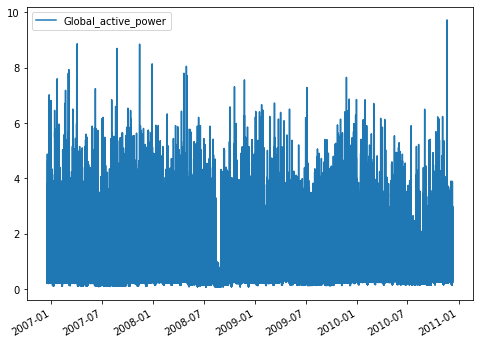

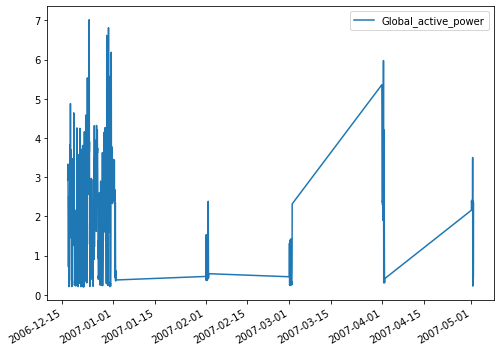

In [207]:
plot_cols = ['Global_active_power']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect the dataset, statistics and cleanup

In [208]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Global_active_power,34154.0,1.096766,1.058464,0.078,0.308,0.612,1.534,9.724


### Splitting the data

We are gonna use (70%, 20%, 10%) split; for the training, validation, and test sets. 

Data is not being randomly shuffled before splitting: by that way; validation/test results are more realistic, by being evaluated on the data collected after the model was trained.

In [209]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [210]:
train_df.isna().sum()


Date                   0
Time                   0
Global_active_power    0
dtype: int64

we have splitted the data into 3 categories; train, validation and test sets.

### Normalizing the data

Before training the NN, we should scale features; and normalization is a common way of that: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation would be computed using the training data so that the models have no access to the values in the validation and test sets. And as a result we get honest metrics by validation and test sets.

In [211]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/tmp/ipykernel_32077/1429736173.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_mean = train_df.mean()
/tmp/ipykernel_32077/1429736173.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_std = train_df.std()


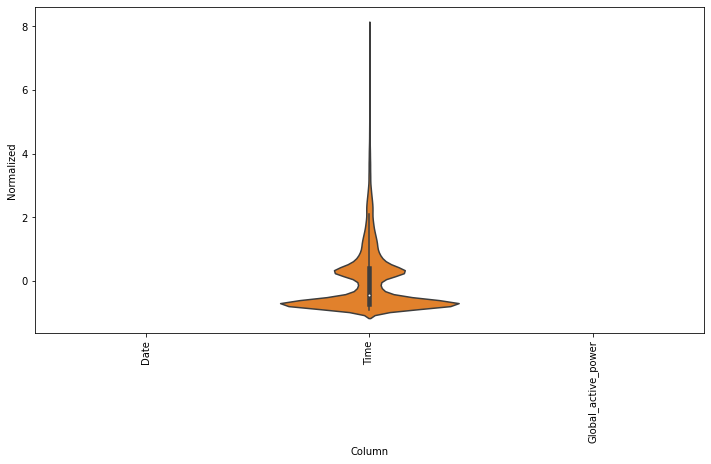

In [212]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))

df_std = df_std.explode('Normalized')
df_std['Normalized'] = df_std['Normalized'].astype('float')
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

scaling the data

In [213]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

train_df = ss.fit_transform(train_df) #using fit_transform so that it can fit on data, and other data can be normalized to same scale
test_df = ss.transform(test_df) #using trasnfrom to get it on same scale as training

/home/harun/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:980: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/harun/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/home/harun/.local/lib/python3.8/site-packages/sklearn/utils/extmath.py:1005: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction**2 / new_sample_count


### Windowing the data

In [218]:
class WindowGen():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [219]:
w1 = WindowGen(input_width=24, label_width=1, shift=24,
                     label_columns=['Global_active_power'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Global_active_power']

In [220]:
w2 = WindowGen(input_width=6, label_width=1, shift=1,
                     label_columns=['Global_active_power'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Global_active_power']

#### Split

In [224]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGen.split_window = split_window

In [226]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

ValueError: Tensor's shape (3, 1, 3, 1) is not compatible with supplied shape [None, 1, None]

#### Plot

In [227]:
w2.example = example_inputs, example_labels


In [234]:
def plot(self, model=None, plot_col='Global_active_power', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGen.plot = plot

In [235]:
w2.plot()

AttributeError: 'WindowGen' object has no attribute 'column_indices'

<Figure size 864x576 with 0 Axes>

This make_dataset method will take a time series DataFrame and convert it to a tf.data.Dataset of (input_window, label_window) pairs using the tf.keras.utils.timeseries_dataset_from_array function:


In [236]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=128,)

  ds = ds.map(self.split_window)

  return ds

WindowGen.make_dataset = make_dataset

The WindowGen object holds **training, validation, and test data**.

we will add properties for accessing them as tf.data.Datasets using the make_dataset method we defined earlier. Also, gonna add a standard example batch for easy access and plotting:

In [237]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGen.train = train
WindowGen.val = val
WindowGen.test = test
WindowGen.example = example

WindowGen object gives us access to the tf.data.Dataset objects, so we can easily iterate over the data.

In [238]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

ValueError: in user code:

    File "/tmp/ipykernel_32077/1766345859.py", line 12, in split_window  *
        labels.set_shape([None, self.label_width, None])

    ValueError: Shapes must be equal rank, but are 4 and 3


In [168]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (128, 6, 3)
Labels shape (batch, time, features): (128, 1, 1)


## Single step models

The simplest model we can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

We are gonna configure a WindowGen object to produce these single-step (input, label) pairs:



In [169]:
single_step_window = WindowGen(
    input_width=1, label_width=1, shift=1,
    label_columns=['Global_active_power'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Global_active_power']

The window object creates tf.data.Datasets from the ***training, validation, and test sets***, allowing us to easily iterate over batches of data.

In [170]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (128, 1, 3)
Labels shape (batch, time, features): (128, 1, 1)


### 1. Baseline model

In [171]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

to evaluate this model:

In [173]:
baseline = Baseline(label_index=column_indices['Global_active_power'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

54/54 [==============================] - 0s 2ms/step - loss: nan - mean_absolute_error: nan


In [174]:
wide_window = WindowGen(
    input_width=24, label_width=24, shift=1,
    label_columns=['Global_active_power'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Global_active_power']

In [175]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (128, 24, 3)
Output shape: (128, 24, 1)


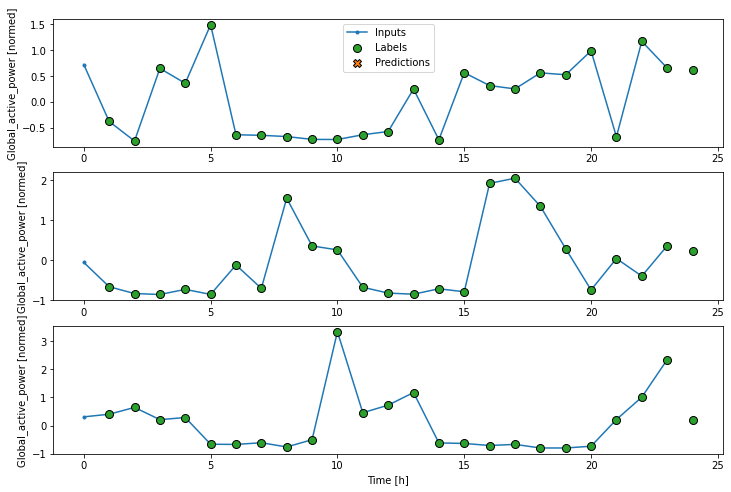

In [176]:
wide_window.plot(baseline)



- The blue Inputs line shows the input global active power at each time step. The model receives all features, this plot only shows the global active power.

- The green Labels dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.

- The orange Predictions crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the Labels.

### 2. Linear model

This is the simplest trainable model we can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:



In [177]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [178]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (128, 1, 3)
Output shape: (128, 1, 1)


In [185]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  opt = tf.optimizers.Adam(clipnorm=1.0) 
  model.compile(optimizer=opt,
                loss=tf.losses.MeanSquaredError(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:


In [186]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
187/187 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
187/187 [==============================] - 1s 3ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/20
54/54 [==============================] - 0s 2ms/step - loss: nan - mean_absolute_error: nan


In [181]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (128, 24, 3)
Output shape: (128, 24, 1)


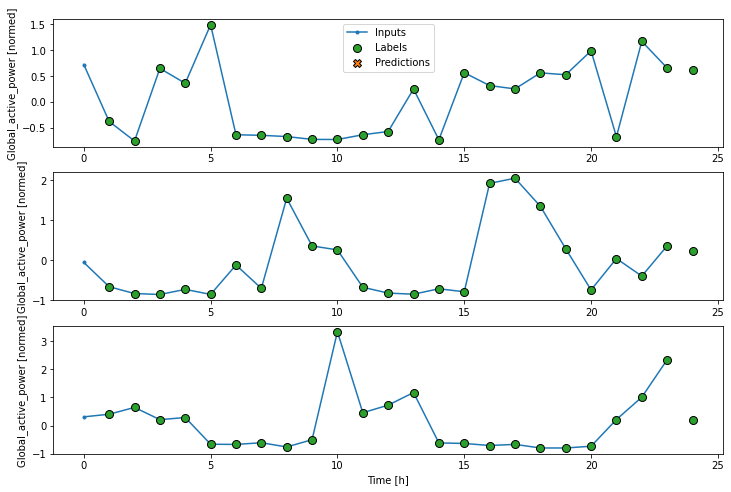

In [182]:
wide_window.plot(linear)


### 3.Dense

In [53]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
748/748 [==============================] - 1s 1ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
214/214 [==============================] - 0s 697us/step - loss: nan - mean_absolute_error: nan



### 4.Convolution neural network


In [62]:
CONV_WIDTH = 3
conv_window = WindowGen(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Global_active_power'])

conv_window


Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Global_active_power']

In [63]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [64]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 12)
Output shape: (32, 1, 1)


In [66]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 12)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [69]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGen(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Global_active_power'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Global_active_power']

In [70]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 12)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


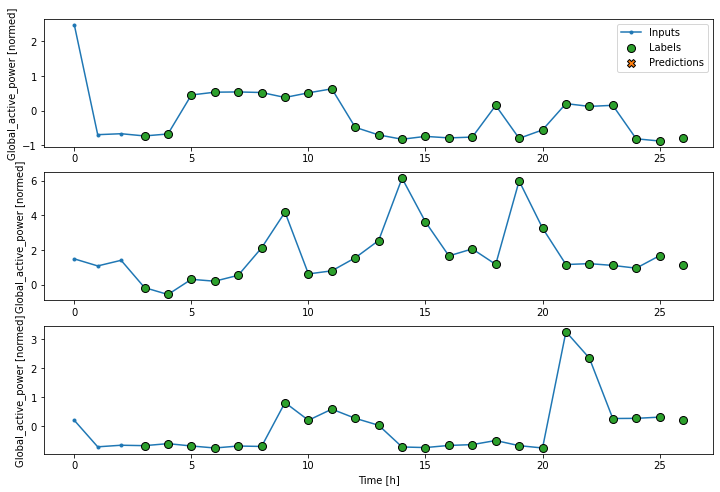

In [71]:
wide_conv_window.plot(conv_model)


### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

We will use an RNN layer called Long Short-Term Memory (tf.keras.layers.LSTM).



In [72]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [73]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 12)
Output shape: (32, 24, 1)
